# Example ML Model
First attempt at a ML model to predict the stopping power on a particle using the ground-state DFT formation enthalpy

In [21]:
%matplotlib inline
from matplotlib import pyplot as plt
import os
import pandas as pd
import numpy as np
from glob import glob
from ase.io import qbox
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import LeavePGroupsOut
from stopping_power import get_charge_density_interpolator, compute_ewald_force
from scipy import stats
from tqdm import tqdm_notebook as tqdm
from pymatgen.io.ase import AseAtomsAdaptor
from multiprocessing import Pool
from matminer.featurizers.site import AGNIFingerprints

## Load in Example Dataset
Parse a QBox output, get the particle position and force acting on it for each frame

In [3]:
def project_force(force, velocity):
    """Get the projection of the force acting against the direction of travel
    
    :param force: ndarray, force acting on particle
    :param velocity: ndarray, velocity of particle
    :return: float, magnitude of force in direction of travel"""
    
    return -1 * np.dot(force, velocity) / np.linalg.norm(velocity)

In [4]:
def load_qbox_data(path):
    """Load in QBox data, compute forces
    
    :param path: str, path to output file
    :return: DataFrame"""
    
    qbox_data = qbox.read_out(path, slice(None))
    return pd.DataFrame({
        'atoms': qbox_data,
        'frame_id': list(range(len(qbox_data))),
        'force': [project_force(frame.get_forces()[-1], frame.get_velocities()[-1]) for frame in qbox_data],
        'position': [frame.get_positions()[-1] for frame in qbox_data],
        'velocity': [frame.get_velocities()[-1] for frame in qbox_data],
        'energy': [frame.get_potential_energy() for frame in qbox_data],
        'file_id': [int(path[:-4].split("_")[-1]),]*len(qbox_data)
    })

Read all the files

In [5]:
data = []
for file in tqdm(glob('256_Al/kpg*.out')):
    try:
        frame = load_qbox_data(file)
    except Exception as exc:
        print(exc)
        continue
    frame['file'] = file
    data.append(frame)
data = pd.concat(data)
print('Read in %d training points'%len(data))


Read in 9800 training points


Compute the timestep

In [6]:
data.sort_values(['file_id', 'frame_id'], ascending=True, inplace=True)

In [7]:
data['timestep'] = list(range(len(data)))

In [8]:
data.set_index('timestep', inplace=True, drop=False)

Compute the displacement

In [9]:
data['displacement'] = (data['position'] - data['position'][0]).apply(np.linalg.norm)

## Plot it
Make sure nothing looks stupid wrong, and that it matches with up Andre's paper.

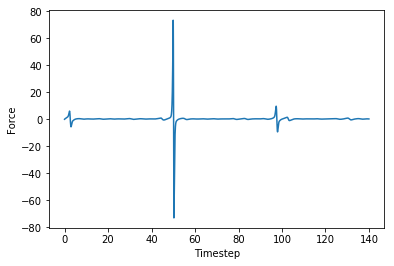

In [10]:
fig, ax = plt.subplots()

ax.plot(data['displacement'], data['force'])

ax.set_xlabel('Timestep')
ax.set_ylabel('Force')

## Determine the Start Point
These simulations have an initial transient, which should not be used to fit the model

Plot the energy. Note the peak at the beginning. This peak is due to adding the particle

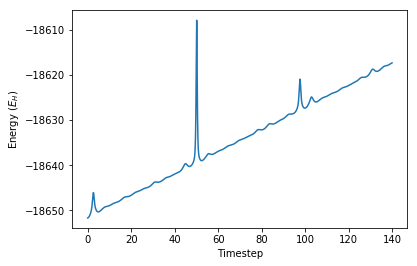

In [11]:
fig, ax = plt.subplots()

ax.plot(data['timestep'], data['energy'])

ax.set_xlabel('Timestep')
ax.set_ylabel('Energy ($E_H$)')

Plot the force over the beginning. Figure out when the first peak goes away

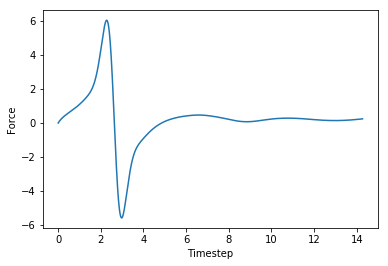

In [12]:
fig, ax = plt.subplots()

ax.plot(data['displacement'][:1000], data['force'][:1000])

ax.set_xlabel('Timestep')
ax.set_ylabel('Force')

Remote the transient (greater than 5 should be good)

In [13]:
data.query('displacement >= 5', inplace=True)

## Compute the Density 
Get it both at the current frame and the previous

In [14]:
charge, cell = get_charge_density_interpolator(os.path.join('256_Al', 'Al_semi_core_gs.cube'))

In [15]:
def get_density(position, velocity, time=0):
    """Get the density as a function of particle position and time
    
    :param position: Series, current particle position
    :param velocity: Series, particle velocity
    :param time: float, time (relative to present)
    :return: charge density"""
    
    # Compute the position
    cur_pos = np.array(position.tolist()) + time * np.array(velocity.tolist())
    
    # Convert it to reduced coordinates
    cur_pos = np.linalg.solve(cell, cur_pos.T) % 1
    return charge(cur_pos.T)

Compute the inputs: charge density at different times

In [16]:
for t in tqdm(np.linspace(1, -5, 7)):
    data['charge_t=%.2f'%t] = get_density(data['position'], data['velocity'], t)

In [17]:
X_cols = [x for x in data.columns if x.startswith('charge')]
y_col = 'force'

Plot charge as a function of time

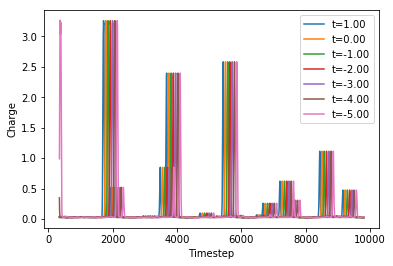

In [18]:
fig, ax = plt.subplots()

for col in X_cols:
    time = col.split("_")[1]
    ax.plot(data['timestep'], data[col], label=time)

ax.legend()
    
ax.set_xlabel('Timestep')
ax.set_ylabel('Charge')

Plot the Charge densities

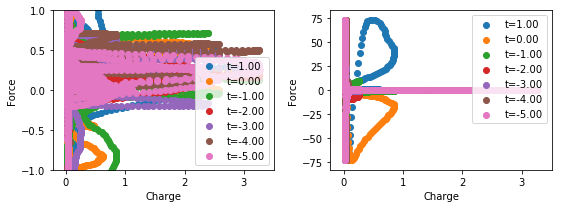

In [19]:
fig, axs = plt.subplots(1,2)

for col in X_cols:
    time = col.split("_")[1]
    for ax in axs:
        ax.scatter(data[col], data['force'], label=time)

for ax in axs:
    ax.legend()

axs[0].set_ylim([-1, 1])
    
for ax in axs:
    ax.set_xlabel('Charge')
    ax.set_ylabel('Force')
    
fig.set_size_inches(8,3)
fig.tight_layout()

## Compute AGNI Fingerprints
Use these to describe the local enviroment around a particle

In [22]:
agni = AGNIFingerprints(directions=['x','y','z'])

In [23]:
def get_agni_fingerprints(atoms):
    """Get the AGNI fingerprints projected in the direction of travel
    
    :param atoms: ase.Atoms, structure
    :return: ndarray, fingerprints projected in the direction of travel"""
    
    # Compute the AGNI fingerprints [i,j] where i is fingerprint, and j is direction
    fingerprints = agni.featurize(AseAtomsAdaptor.get_structure(atoms), -1).reshape((3, -1)).T
    
    # Project into direction of travel
    my_velocity = atoms.get_velocities()[-1,:]
    fingerprints = np.dot(
        fingerprints,
        my_velocity
    ) / np.linalg.norm(my_velocity)
    
    return fingerprints
get_agni_fingerprints(data['atoms'].iloc[0]);

In [24]:
labels = ['AGNI_eta=%.2e'%x for x in agni.etas]

In [25]:
data = data.assign(**dict(zip(labels,zip(*[get_agni_fingerprints(x) for x in tqdm(data['atoms'])]))))

## Compute Ewald Forces
Get the nucleus-nucleus repulsion force acting on the particle in the direction of travel

In [26]:
data['ewald_force'] = [compute_ewald_force(x, acc=2) for x in tqdm(data['atoms'])]

Plot the Coulomb repulsion against observed force

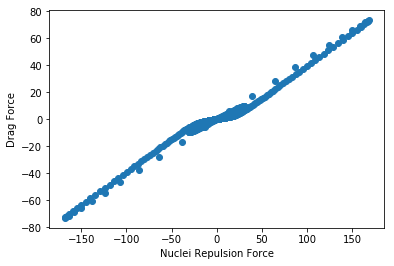

In [27]:
fig, ax = plt.subplots()

ax.scatter(data['ewald_force'], data['force'])

ax.set_xlabel('Nuclei Repulsion Force')
ax.set_ylabel('Drag Force')

Compute scaling between nuclei repulsion force and the "drag" force, which could account for the effect of screening
Only consdier this at large forces (e.g., where the nucleus-nuclues repulsion dominants)

In [28]:
force_cutoff = np.percentile(data['ewald_force'], 99)

In [29]:
fit_data = data.query('ewald_force > %f'%force_cutoff)
force_scaling = LinearRegression(fit_intercept=False).fit(fit_data['ewald_force'].values[:,np.newaxis],
                                                          fit_data['force']).coef_[0]
data['ewald_scaled'] = force_scaling * data['ewald_force']
del fit_data
print('Scale factor:', force_scaling)

Scale factor: 0.405559823865


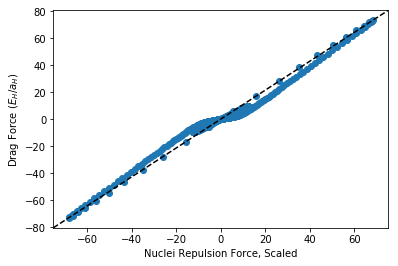

In [30]:
fig, ax = plt.subplots()

ax.scatter(data['ewald_scaled'], data['force'])

ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())

ax.plot(ax.get_xlim(), ax.get_ylim(), 'k--')

ax.set_xlabel('Nuclei Repulsion Force, Scaled')
ax.set_ylabel('Drag Force ($E_H / a_H$)')

## Compute the Drag Force without the Ion-Ion Repulsion
This might be easier to fit to

In [31]:
data['force_noion'] = data['force'] - data['ewald_scaled']

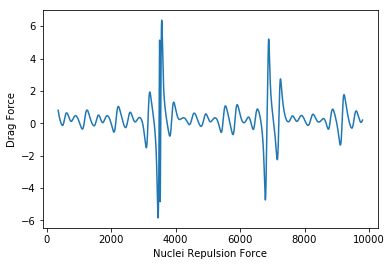

In [32]:
fig, ax = plt.subplots()

ax.plot(data['timestep'], data['force_noion'])

ax.set_xlabel('Nuclei Repulsion Force')
ax.set_ylabel('Drag Force')

## Save everything to disk
Except `Atoms` objects

In [33]:
data.drop('atoms', axis='columns').to_csv('training_set.csv', index=False)